In [52]:
%load_ext autoreload
%autoreload 2

import datetime
import gc
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb
import re
import json

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 

from preprocessing import load_messages, format_forks, replace_substring
from preprocessing import get_currency, get_tax, apply_tax
from preprocessing import add_levels_cols, add_levels_forks
from preprocessing import get_quantiles, estimate_level_forks
from preprocessing import box_plot_by_level
from preprocessing import TIME_RANGES_DICT, YEAR_RANGES_DICT, LEVELS_DICT
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Загрузка и предварительная очистка данных 
Для исследования мы испоьзовали свежий дамп слака ODS от 06 марта 2021 года.<br>
Каналы jobs и jobs hr. Загрузим сообщения в pandas df и очистим от лишней информации.

In [2]:
messages = load_messages('jobs', 'jobs_hr')

Загружено 47767 cообщений
	Удалены технические сообщения: 6864 сообщений
	Дата и время округлены до секунд и переведены в datetime формат
	Текст приведен к маленьким буквам и очищен от лишних пробелов
Осталось 40903 cообщений


### Кол-во сообщений

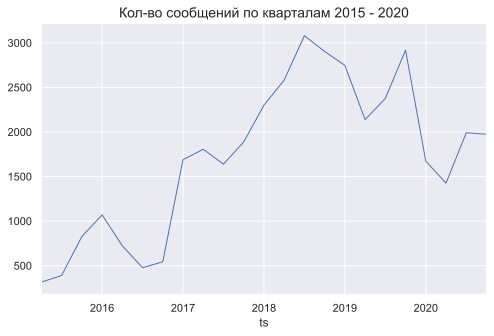

In [3]:
plt.figure(figsize = (8, 5))
messages[messages.ts.dt.year < 2021].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                 label='всего')
plt.title('Кол-во сообщений по кварталам 2015 - 2020', size=14)
plt.show()

Общее кол-во сообщений достигло <b>максимума в 3 квартале 2018 года</b>.<br>
После этого активность снижалась - резкое <b>падение активности произошло в 2020 году</b>

#### Что это коронакризис или хайп по data science уже прошел?

Здесь мы смотрим на все сообщения - это и сами вакансии и комментарии пользователей.<br>
До 2017 года тредов вообще не было и все сообщения сыпались в общий канал.<br>
У части сообщений и сейчас нет треда - если никто не оставил комментарий.<br>

Для дальнейшего анализа нам нужно отделать сообщения с вакансиями от комментариев пользователей.<br>
Самый простой подход - это считать вакансией все сообщения с которых начинается тред (thread_ts = ts).<br>
Но тогда мы потеряем всю статистику за 2015-2016 года.<p>
    
Второй вариант - это обучить простую модель на этой метке и разделить с ее помощью сообщения без треда.<br>

### Классификация сообщений на вакансии и комментарии

В качесстве признаков будет использовать count по всем словам в сообщении.

In [4]:
df = messages.loc[~messages.thread_ts.isna(),:]

# Генерируем метку для обучения
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')


# Выбираем только нужные для обученяи колнки
df = df.loc[:,['is_job', 'text']].reset_index(drop=True)

# Делим датасет на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ['text']], df['is_job'],
                                                    test_size = 0.3, random_state = 555)

# CountVectorizer для текста
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(X_train['text'])
word_cols = countvectorizer.get_feature_names()

# Делим на трейн и тест и обучаем модель
X_train = countvectorizer.transform(X_train['text']).toarray() 
X_test = countvectorizer.transform(X_test['text']).toarray()

gbm1 = lgb.LGBMClassifier(num_leaves=11, n_estimators=300, feature_fraction=0.1, bagging_fraction=0.3)
gbm1.fit(X_train, y_train.values)

del X_train, y_train, df
gc.collect()

3117

#### Качество модели
<p>Качества этой простой модели более чем достаточно для поставленной задачи.<br>
Тем более, что разметка для обучения шумная и не на 100% точная.<p>

In [5]:
# Считаем метрики
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy для наивной модели {accuracy_baseline}')
pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy для модели {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

df = countvectorizer.transform(messages['text']).toarray()
messages['is_job'] = gbm1.predict(df)
# del df

Accuracy для наивной модели 93.2
Accuracy для модели 99.6
F1 score 0.970873786407767


#### Важность признаков
Вакансии и комментарии легко сплитятся по используемым словам.
Например на вакансию указывают такие слова: 
<li> навыки: python, sql, data, английский
<li> ссылки и email: http, https, mailto
<li> слова связанные с вилкой зп: вилка, от, fork, 200, 50 и т.д.
<li> другие слова часто встречаемые в описании вакансий: опыт, привет (в комментах люди редко здороваются), на, ищем, офис, москва, требования<p>
    
На комментарий указывают разговорные слова характерные для ответов:<br>
вот, просто, так, уже, есть, gt (использование цитаты)<p>

Ниже можно посомотреть top50 признаков из модели по версии shap

#### Нарисуем шап для модели

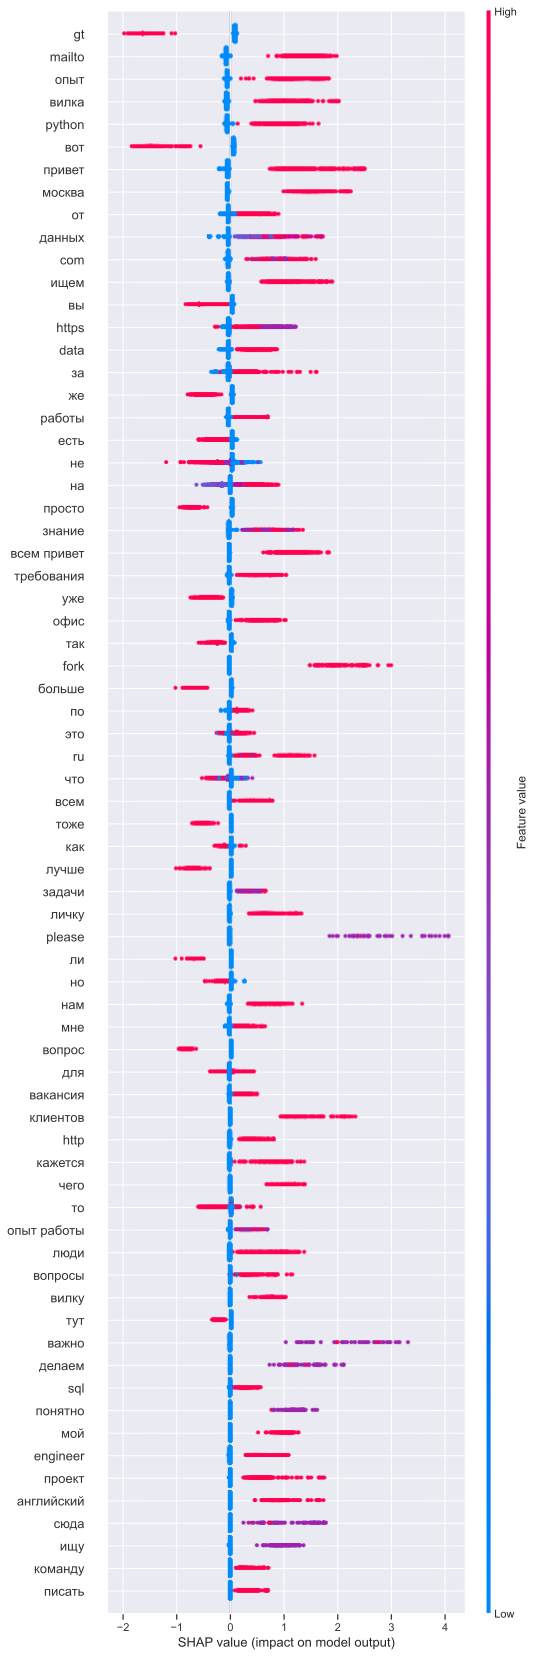

In [6]:
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=70, feature_names=word_cols)

### Кол-во сообщений с вакансиями

Теперь, с помощью нашей модели можно выделить только вакансии и посмотреть на их динамику<br>
Паника отменяется, товарищи, <b>кол-во вакансий по прежнему растет!</b><br>
К концу 2020 года - было чуть меньше 100 вакансий в месяц, а за февраль 2021 уже почти 140!

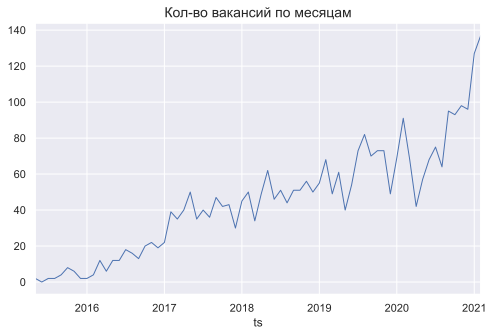

In [7]:
# Выбираем только сообщения с вакансиями
df = messages[messages.is_job == 1].reset_index(drop=True)

# Убираем сообщения начинающиеся с тега пользователя
df = df[df['text'].str[0:2] != '<@']

plt.figure(figsize = (8, 5))
df[(df.ts < '2021-03-01')].resample('M', on = 'ts')['ts'].count().plot(linewidth=1)
plt.title('Кол-во вакансий по месяцам', size=14)
plt.show()

### Парсинг зарплат 

По правилам сообщества в каждой вакансии должна быть указана зарплатная вилка.<br>
Но на практике спарсить их оказалось не так просто.<p>
    
#### Очистка текста

В вакансиях есть много других цифр помимо зарплатных вилок, которые машают анализу.
Для начала очистим текст от них:
<li>Ссылки
<li>Номера телефонов
<li>Года
<li>Интервалы времени
<li>Премии

In [12]:
# Ссылка
link = r'<.*?>'

# Номер телефона
tel = r'([78][-\( ]*\d{3}[-\) ]*\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3}|' + \
      r'\(\d{3}\)\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3})'

# Удаляем данные для премий
bonus = r'(\+.{0,5}?\d{2,3}.{0,25}?преми|\+ \d{2-3}-\d{2,3}|\+ \d{2,3})'

# Очищаем текст
df['clean_text'] = df.text
# Удаляем все ссылки из текста
df['clean_text'] = df.clean_text.str.replace(link, ' ')
# Удаляем телефоны из текста
df['clean_text'] = df.clean_text.str.replace(tel, ' ')
# Удаляем премии из текста
df['clean_text'] = df.clean_text.str.replace(bonus, ' ')
# Удаляем года из текста
df['clean_text'] = df.clean_text.replace(YEAR_RANGES_DICT, regex=True)
# Удаляем время из текста
df['clean_text'] = df.clean_text.replace(TIME_RANGES_DICT, regex=True)

#### Базовые регулярки для зарплатных вилок

Для начала сделаем несколько регулярок:
<li> Реглярка для извеления цифрв в 4 форматах
<li> Регулярка для выражения между цифрами если они отностятся к одной вилке
<li> Регулярка для выражений которые часто идут до указания зарпланой вилки
<li> Регулярка для выражений которые идут после зарплатной вилки

In [13]:
number = r'([123456789]\d{0,2}[,\'\. ]?\d0{2}|[123456789]\d{2}0{1,2}|[123456789]\d{1,2}|[123456789]\d{0,1}[\.,\']\d{1,3})'

middle = r'[ \t]*[^0123456789\.,\'%]{0,9}?(?:-|до|–|—|to|-)[ \t]*[^0123456789\.,\'%]{0,1}?'

start = r'(?:net|gross|гросс|нет|rub|$|€|£|eur|dol|mid|sen|jun|мидл|синь|джун|зп|з\\п|плат|компенсац|' + \
        r'вилк|з/п|доход|fork|moneys|salary|moneyparrot|деньг|оклад|условия|ставка|_plug).{0,100}?\s*?'

end = r'[ \t]*?[^0123456789]{0,3}?(?:k |к |тыс\.|т\.р|net|gross|гросс|нет|rub|$|€|£|eur|dol|mid|' + \
      r'sen|jun|мидл|синь|jun|р |джун)'

#### Финальные регулярки для извлечения вилок

Теперь из базовых регулярок можно собрать финальные. В порядке приоритета:
<ol>
    <li>Полные вилки от и до и с совпадением по регулрякам до и после
    <li>Полные вилки от и до и с совпадением по регулрякам после
    <li>Полные вилки от и до и с совпадением по регулрякам до
    <li>Полные вилки от и до
    <li>Вилки из одной цифры с совпадением по регулрякам до и после
    <li>Вилки из одной цифры с совпадением по регулрякам после
    <li>Вилки из одной цифры с совпадением по регулрякам до

In [14]:
fork_1 = start + number + middle + number + end
fork_2 = number + middle + number + end
fork_3 = start + number + middle + number
fork_4 = number + middle + number
fork_5 = start + number + end

In [15]:
# Парсим вилки с использованием полученных регулярок
forks_1 = df.clean_text.str.findall(fork_1)
forks_2 = df.clean_text.str.findall(fork_2)
forks_3 = df.clean_text.str.findall(fork_3)
forks_4 = df.clean_text.str.findall(fork_4)
clean_text = df.clean_text.str.replace(fork_4, ' ')
forks_5 = clean_text.str.findall(fork_5)

forks_list = []
for i, row in df.iterrows():
    forks = forks_1[i] + forks_2[i] + forks_3[i] + forks_4[i] + forks_5[i]
    forks_list.append(forks)
    
df['forks'] = forks_list

print(f'Всего найдено вилок {np.sum(df.forks.str.len()>0)} из {len(df)}')

Всего найдено вилок 2555 из 3187


#### Пиведем все вилки к одному формату

Приведем вилки состоящие из одного числа к виду нижняя граница - верхняя граница<br>
Распарсим числа из строкового формата и приведем к тысячам<br>
Удалим дубли по вилкам и вилки с несовпадениями по границам

In [16]:
df['forks'] = format_forks(df)
print(f'Кол-во корректно форматированных вилок {np.sum(df.forks.str.len()>0)}')   

Кол-во корректно форматированных вилок 2537


#### Добавим валюту и признак net или гросс
Пересчитаем зарплаты в рублях в net

In [27]:
df['cur'] = get_currency(df)
print(f'Валюты вакансий: {df.cur.value_counts().to_dict()}')

df['tax'] = get_tax(df)
print(f'До/после налогов: {df.tax.value_counts().to_dict()}')

df['forks'] = df.apply(apply_tax, axis=1)

Валюты вакансий: {'rub': 1828, 'usd': 416, 'eur': 280, 'gbp': 13}
До/после налогов: {'net': 1737, 'gross': 800}


#### Добавим информацию по уровням
Часто в одной вакансии ищут сразу несколько специалистов, идет перечисление уровней и вилок.

In [28]:
print(f'Вакансий с двуми и более вилками: {np.sum(df.forks.str.len() > 1)}')

Вакансий с двуми и более вилками: 477


Добавим грейд вакансии как новый признак. И если у вакансии несколько вилок распределим их по уровням.

In [41]:
df = add_levels_cols(df)
df = add_levels_forks(df)
print('Кол-во вакансий по позициям:')
print(f'\tjunior: {np.sum(df.junior)}')
print(f'\tmiddle {np.sum(df.middle)}')
print(f'\tsenior: {np.sum(df.senior)}')
print(f'\tlead: {np.sum(df.lead)}')

Кол-во вакансий по позициям:
	junior: 534
	middle 898
	senior: 967
	lead: 810


### Анализ зарплат

#### Зарплатные вилки по грейдам

Возьмем только вакансии указанные в рублях, для каждого грейда уберем выбросы по зарплатной вилки<br>

In [42]:
rub = df[df.cur == 'rub']
level_bounds = get_quantiles(rub)
rub['junior_fork'], rub['middle_fork'], rub['senior_fork'], rub['lead_fork'] = "[]", "[]", "[]", "[]"
rub = estimate_level_forks(rub, level_bounds)

for level in LEVELS_DICT.keys():
    rub[level+'_fork'] = rub[level+'_fork'].apply(json.loads)

Границы вилок для junior: {'bottom': [26.0, 100.0], 'upper': [38.0, 150.0]}
Границы вилок для middle: {'bottom': [87.0, 174.0], 'upper': [132.0, 250.0]}
Границы вилок для senior: {'bottom': [100.0, 250.0], 'upper': [152.0, 385.0]}
Границы вилок для lead: {'bottom': [100.0, 336.0], 'upper': [150.0, 500.0]}


In [54]:
box_plot_by_level(rub)

На этом графике мы смотрим на распределение среднего между верхней и нижней границей вилки.<br>
Настоящие цифры могут буть немного смещены вверх или вниз в зависимости от того,<br> 
куда в среднем тяготеет финальный оффер.<p>

#### Зарплатные вилки по уровням